In [1]:
import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

import matplotlib.pyplot as plt
import numpy as np

In [2]:
def f (x):
    return np.sin (x) + 2 * np.cos (14 * x) - 2 * np.sin (6 * x)

#x = torch.tensor ([-1, -0.5, 0, 0.5, 1])
#y = torch.tensor ([ f (elem) for elem in x ])
x = torch.linspace (-1, 1, 20)
y = torch.tensor (f (x))
#x = x + torch.randn (x.shape) * 0.05
#print (x)


<ipython-input-2-2daccd8d9a01>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor (f (x))


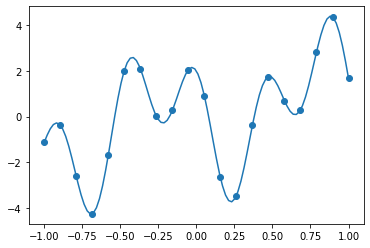

In [3]:
test_x = np.linspace (-1, 1, 100)
test_y = f (test_x)
plt.scatter (x, y)
plt.plot (test_x, test_y)
#x = torch.linspace (-1, 1, 10)
#y = torch.tensor (f (x))
#x = x + torch.randn (x.shape) * 0.05


In [4]:
def plot(
    x,
    y,
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(x.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(-1, 1, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-1, 1, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(-1.2, 1.2)

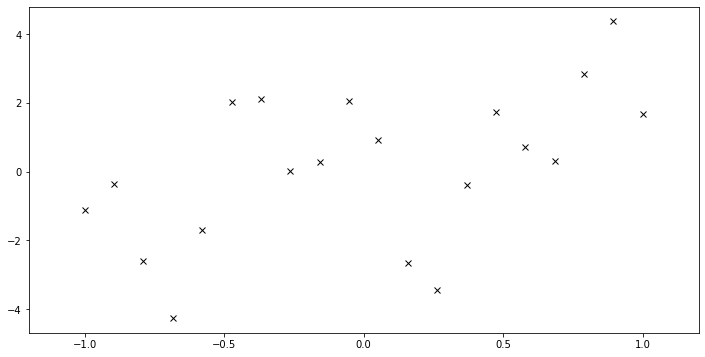

In [5]:
plot(x, y, plot_observed_data=True)

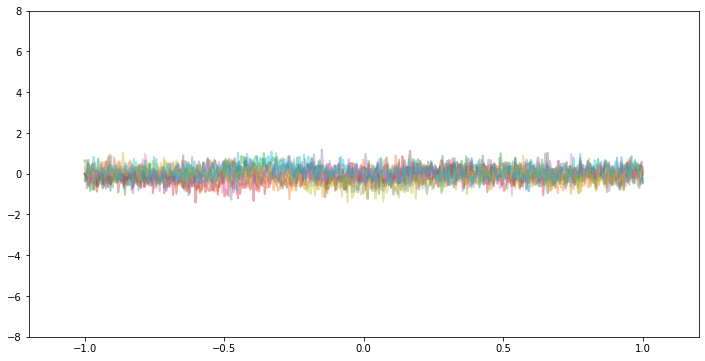

In [6]:
lengthscale = dist.LogNormal(-1, 1) 
variance = dist.LogNormal (0, 2)
kernel = gp.kernels.RBF(
    input_dim=1, variance=variance, lengthscale=lengthscale
)
gpr = gp.models.GPRegression(x, y, kernel, noise=torch.tensor(1e-1))
plot(x, y, model=gpr, kernel=kernel, n_prior_samples=10)
_ = plt.ylim((-8, 8))

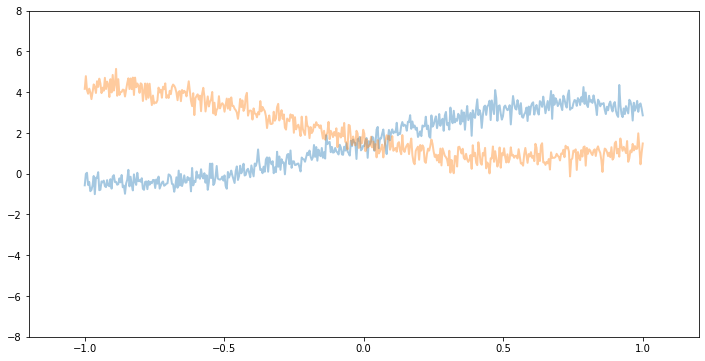

In [7]:
kernel2 = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(6.0), lengthscale=torch.tensor(1)
)
gpr2 = gp.models.GPRegression(x, y, kernel2, noise=torch.tensor(0.1))
plot(x, y, model=gpr2, kernel=kernel2, n_prior_samples=2)
_ = plt.ylim((-8, 8))

In [8]:
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
#loss = 0
variances = []
lengthscales = []
noises = []
num_steps = 2000
for i in range(num_steps):
    variances.append(gpr.kernel.variance.item())
    noises.append(gpr.noise.item())
    lengthscales.append(gpr.kernel.lengthscale.item())
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

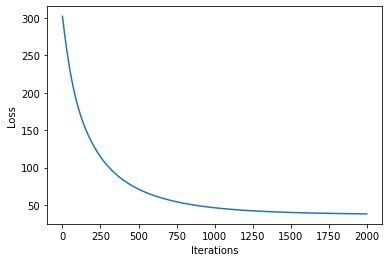

In [9]:
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text


plot_loss(losses)

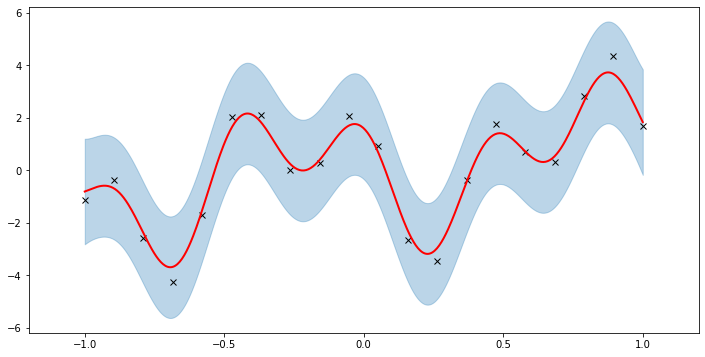

In [10]:
plot(x, y, model=gpr, plot_observed_data=True, plot_predictions=True)